# Perfect tests 

The first model supposes the samples are independent and the test is perfect,
which means that $\theta_i = p_i$ for all $i$. Therefore it only considers the risk factors $\boldsymbol{x}_i$. 

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(\theta_i), \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta, 
  \end{aligned}  
\end{equation}

where $v^T$ denotes the transpose of $v$, and $g(\cdot)$ is a link function.
The parameter $\beta \in \mathbb{R}^{k}$ is the risk effects. For Bayesian inference, priors on
$\beta$ and $\theta$ must be included. We use $\beta ~ \sim \operatorname{Normal}(\mu, \Sigma)$
and $\theta \sim \operatorname{Beta}(a^{p}, b^p)$, where $\mu
\in \mathbb{R}^{k}$, $\Sigma \in \mathbb{R}^{k\times k}$ symmetric positive-definite matrix,
$a^p \in \mathbb{R}_{++}$, and $b^p \in \mathbb{R}_{++}$
are fixed hyperparameters. 

In [329]:
import numpy as np
import pandas as pd
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy.stats import t as t_dist

import pickle
from tqdm import tqdm

import sys  
sys.path.insert(0, '../scripts/')

## Notebook settings

In [3]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan model 

As usual, we can saved a compiled version for future experiments. 

In [4]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/perfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/perfect_test.stan')
    with open('../models/primary_model/pickles/perfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

The simpler model is what follows written in Stan. 

In [5]:
print(sm.model_code)

data {
    int<lower=0> n_samples;
    int<lower=0> n_predictors; 
  
    int<lower=0, upper=1> Y[n_samples];
    matrix[n_samples, n_predictors] X;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower=0> alpha_p; 
    real<lower=0> beta_p;
}
transformed data {
  matrix[n_predictors, n_predictors] sigma_beta;
  sigma_beta = cholesky_decompose(Sigma);
}
parameters {
    vector[n_predictors] normal_raw; 
    real<lower=0, upper=1> prev; 
}
transformed parameters {
    vector[n_predictors] effects = mu + sigma_beta * normal_raw;
}
model {
    normal_raw ~ std_normal();
    prev ~ beta(alpha_p, beta_p);
    Y ~ bernoulli_logit(logit(prev) + X * effects);
}
generated quantities {
  vector[n_predictors] effects_prior = multi_normal_rng(mu, Sigma); 
  real<lower = 0, upper = 1> prev_prior = beta_rng(alpha_p, beta_p);  
}


## Identifiability 

Here we access the identifiability of the model subject to uncentered $x$. 

In [70]:
n_samples    = 500
n_predictors = 1
  
x = ro.multivariate_normal(mean = [15], 
                           cov = np.eye(n_predictors),
                           size = n_samples)

In [6]:
# Normalization
x_norm = (x - x.mean(axis=0)) #/x.std(axis = 0, ddof = 0)

andAnd now we define the parameters we want to estimate

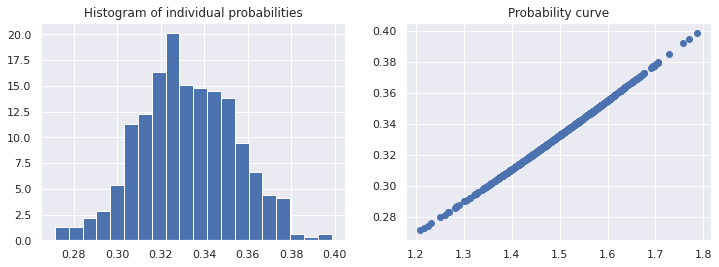

In [21]:
beta = np.array([0.1]).reshape(-1,1)
prevalence = 0.1
theta = expit(logit(prevalence) + x@beta)

T = ro.binomial(n = 1, p = theta)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(theta, density = True, bins = 20)
ax[1].scatter(x@beta, theta)
ax[0].set_title('Histogram of individual probabilities')
ax[1].set_title('Probability curve')

plt.show()

In [11]:
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "Y"            : T.flatten(),
    "X"            : x,
}

T.mean()

0.092

Now we describe the necessary pieces to the model. 

In [12]:
Sigma   = np.eye(1)
mu      = np.zeros(1)
alpha_p = 1
beta_p  = 1

data.update({
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p
})

How the numerical part of the problem enters the picture

In [13]:
%%time
fit_perfect = sm.sampling(data=data, iter=4000)
summary = az.summary(fit_perfect)

CPU times: user 221 ms, sys: 35.2 ms, total: 257 ms
Wall time: 1.39 s


The summary

In [15]:
summary.insert(0, 'real_values', (*tuple(beta.flatten()), prevalence, 0, 0, 0))
summary

,real_values,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
normal_raw[0],0.1,-0.045,0.071,-0.177,0.086,0.002,0.002,1000.0,969.0,1.0
prev,0.1,0.488,0.216,0.109,0.867,0.007,0.005,1001.0,956.0,1.0
effects[0],0.0,-0.045,0.071,-0.177,0.086,0.002,0.002,1000.0,969.0,1.0
effects_prior[0],0.0,-0.002,1.005,-1.813,1.981,0.011,0.008,8086.0,7559.0,1.0
prev_prior,0.0,0.500,0.289,0.012,0.950,0.003,0.002,8130.0,7750.0,1.0


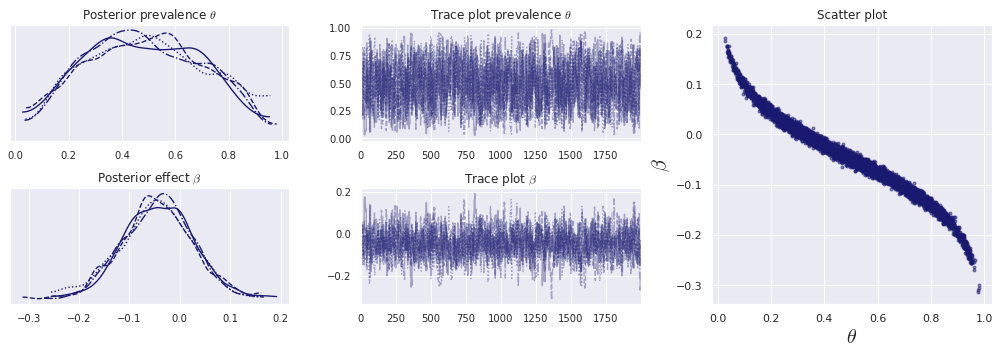

In [16]:
fig, ax = plt.subplots(2,3, figsize = (14,5))
az.plot_trace(fit_perfect, var_names=('prev', 'effects'), kind = 'trace', axes = ax, 
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', '-.', ':']})

ax[0,0].set_title(r'Posterior prevalence $\theta$')
ax[0,1].set_title(r'Trace plot prevalence $\theta$')
ax[1,0].set_title(r'Posterior effect $\beta$')
ax[1,1].set_title(r'Trace plot $\beta$')

gs = ax[0, 2].get_gridspec()
# remove the underlying axes
for i in ax[0:, -1]:
    i.remove()
axbig = fig.add_subplot(gs[0:, -1])

az.plot_pair(
    fit_perfect, var_names=["prev", "effects"], scatter_kwargs = {'color': 'midnightblue', 'alpha': 0.5}, 
    ax = axbig
)
axbig.set_ylabel(r"$\beta$", fontsize = 20)
axbig.set_xlabel(r"$\theta$", fontsize = 20)
axbig.set_title('Scatter plot')

fig.tight_layout(pad=1.0)
#plt.savefig('../images/identifiability_perfect_tests_scaled_x.pdf', bbox_inches = 'tight')
plt.show()

## Fake-data simulation 

In this section, we describe data created artificially as it was generated by this model. It serves as a confirmation of functionality of the code and validation of statistical procedures. 

In [239]:
def simulation(n_samples, normal_parameters, cauchy_parameters, discrete_parameters, 
               beta, prevalence, seed, priors = None):
    
    ro = np.random.RandomState(seed)
    
    n_pred_1 = normal_parameters['n_pred']
    n_pred_2 = cauchy_parameters['n_pred']
    n_pred_3 = discrete_parameters['n_pred'] 
    
    n_predictors = n_pred_1 + n_pred_2 + n_pred_3
    x = np.zeros((n_samples, n_predictors))
    
    if n_pred_1 >= 1: 
        x[:, :n_pred_1] = ro.multivariate_normal(mean = normal_parameters['mean'], 
                                                 cov = normal_parameters['cov'],
                                                 size = n_samples)
    if n_pred_2 >= 1: 
        gamma = cauchy_parameters['scale']
        mean = cauchy_parameters['mean']
        x[:, n_pred_1:-n_pred_3] = gamma * ro.standard_cauchy(size = (n_samples, n_pred_2)) + mean

    if n_pred_3 >= 1: 
        x[:, -n_pred_3:] = ro.binomial(n = 1, p = discrete_parameters['p'], size = (n_samples, n_pred_3))
        
    x[:, :-n_pred_3] = 0.5 * (x[:, :-n_pred_3] - x[:, :-n_pred_3].mean(axis=0))/x[:, :-n_pred_3].std(axis=0, ddof=0)
        
    theta = expit(logit(prevalence) + x@beta)
    T = ro.binomial(n = 1, p = theta)
    
    fig, ax = plt.subplots(1,2,figsize=(12,4))
    ax[0].hist(theta, density = True, bins = 20)
    ax[1].scatter(x@beta, theta)
    ax[0].set_title('Histogram of individual probabilities')
    ax[1].set_title('Probability curve')
    plt.show()
    
    if priors is None:
        priors = {"normal": {"Sigma": np.eye(n_predictors), "mu": np.zeros(n_predictors)}, 
                  "beta": {"alpha_p": 1/2, "beta_p": 1/2}}
    
    data = {
        "n_samples"    : n_samples,
        "n_predictors" : n_predictors,
        "Y"            : T.flatten(),
        "X"            : x,
        "Sigma"        : priors["normal"]["Sigma"],
        "mu"           : priors["normal"]["mu"],
        "alpha_p"      : priors["beta"]["alpha_p"],
        "beta_p"       : priors["beta"]["beta_p"]
    }
    return data, theta

A simple example to start!

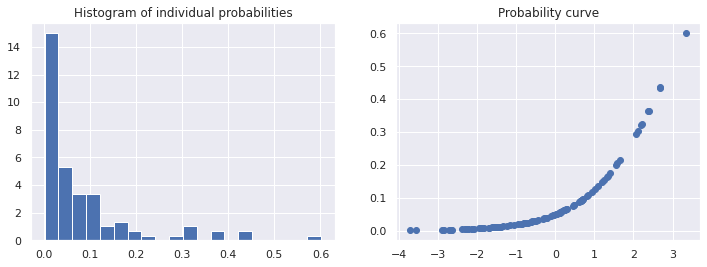

In [301]:
beta = np.array([-0.1, 2.5, 1.4, -1.8, 0.3])

data,  theta = simulation(n_samples=100, 
                          normal_parameters={'n_pred': 3, 'mean': np.zeros(3), 'cov': np.eye(3)}, 
                          cauchy_parameters={'n_pred': 0, 'mean': np.zeros(3), 'scale': np.ones(3)}, 
                          discrete_parameters={'n_pred': 2, 'p': [0.3, 0.7]},
                          beta=beta,
                          prevalence=0.05,
                          seed = 489320, 
                         )                        

In [302]:
%%time
fit_perfect = sm.sampling(data=data, iter=4000, pars = ['prev', 'effects'])
summary = az.summary(fit_perfect)

CPU times: user 144 ms, sys: 53.4 ms, total: 197 ms
Wall time: 975 ms


In [303]:
summary.insert(0, 'real_values', (0.05, *tuple(beta.flatten())))
summary

,real_values,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.05,0.064,0.037,0.010,0.132,0.000,0.000,5063.0,4539.0,1.0
effects[0],-0.10,-0.516,0.607,-1.644,0.647,0.007,0.006,8383.0,5946.0,1.0
effects[1],2.50,1.242,0.620,0.097,2.415,0.007,0.005,7428.0,5659.0,1.0
effects[2],1.40,0.578,0.660,-0.671,1.789,0.007,0.006,7792.0,6006.0,1.0
effects[3],-1.80,-0.816,0.696,-2.067,0.559,0.008,0.007,8089.0,5219.0,1.0
effects[4],0.30,0.341,0.647,-0.849,1.553,0.009,0.007,5548.0,5343.0,1.0


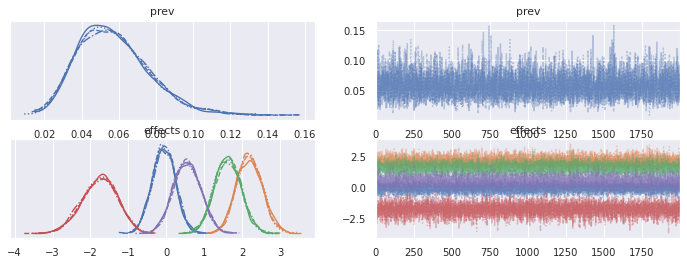

In [243]:
ax = az.plot_trace(fit_perfect, var_names=['prev', 'effects'])
plt.show()

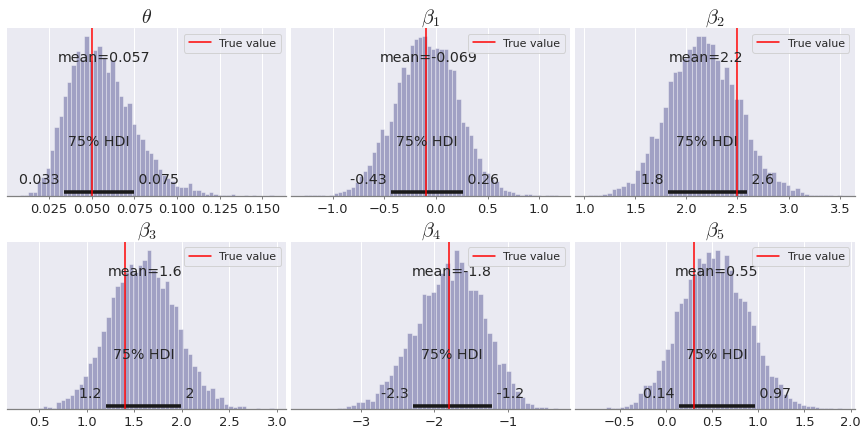

In [244]:
fig, ax = plt.subplots(2,3,figsize = (12,6))
az.plot_posterior(fit_perfect, var_names=['prev', 'effects'], ax = ax, kind = 'hist', 
                  hdi_prob = 0.75, color = 'midnightblue', textsize = 13)

ax[0,0].set_title(r'$\theta$', fontsize = 20)
for k in range(5): 
    i = (k+1) // 3
    j = (k+1) % 3
    ax[i,j].set_title(r'$\beta_{}$'.format(k+1), fontsize = 20)
    
for k, real in enumerate((0.05, *tuple(beta.flatten()))): 
    i = k // 3
    j = k % 3
    ax[i,j].axvline(real, color = 'red', label = 'True value')
    ax[i,j].legend()

fig.tight_layout(pad = 0.5)
#plt.savefig('../images/posterior_perfect_tests_exp1.pdf', bbox_inches = 'tight')
plt.show()

In [245]:
theta_hat = expit(logit(summary.loc["prev", "mean"]) + data["X"]@summary["mean"].values[1:])
theta_hat_order = np.sort(theta_hat)

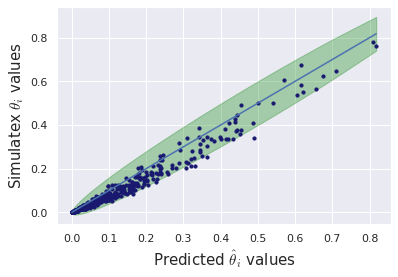

In [249]:
fig, ax = plt.subplots()
ax.fill_between(x = theta_hat_order, 
                y1 = theta_hat_order - 2*np.sqrt(theta_hat_order*(1-theta_hat_order)/100), 
                y2 = theta_hat_order + 2*np.sqrt(theta_hat_order*(1-theta_hat_order)/100),
                alpha = 0.3, 
                color = 'green')
ax.scatter(theta_hat, theta, color = 'midnightblue', s = 10)
ax.plot(np.linspace(min(theta_hat), max(theta_hat), 100), np.linspace(min(theta_hat), max(theta_hat), 100))

ax.set_xlabel(r"Predicted $\hat{\theta}_i$ values", fontsize = 15)
ax.set_ylabel(r"Simulatex $\theta_i$ values", fontsize = 15)

#plt.savefig("../images/predicted-vs-simulated-perfect-tests.pdf", bbox_inches="tight")

### Coverage

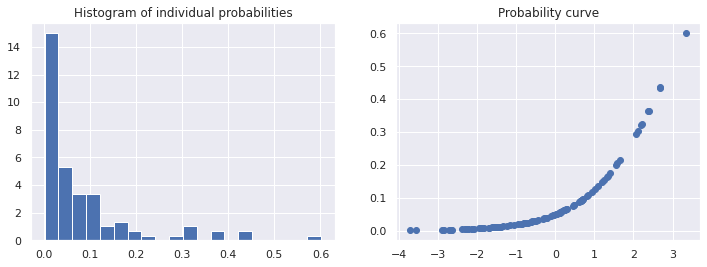

100%|██████████| 1000/1000 [10:51<00:00,  1.54it/s]


In [81]:
beta = np.array([-0.1, 2.5, 1.4, -1.8, 0.3])
prevalence = 0.05

data,  theta = simulation(n_samples=100, 
                          normal_parameters={'n_pred': 3, 'mean': np.zeros(3), 'cov': np.eye(3)}, 
                          cauchy_parameters={'n_pred': 0, 'mean': np.zeros(3), 'scale': np.ones(3)}, 
                          discrete_parameters={'n_pred': 2, 'p': [0.3, 0.7]},
                          beta=beta,
                          prevalence=prevalence,
                          seed = 489320, 
                          priors = {"normal": {"mu": [0, 2, 1, -1, 0], "Sigma": 10 * np.eye(5)}, 
                                    "beta": {"alpha_p": 1, "beta_p": 1}}
                         )    

counter = np.zeros(6)
parameters = np.array([prevalence, *(tuple(beta.flatten()))])

for n_fakes in tqdm(range(1000)): 

    T = np.random.binomial(n = 1, p = theta)
    data['Y'] = T.flatten()
    fit_perfect = sm.sampling(data=data, warmup = 1000, iter=1500, pars = ['prev', 'effects'])
    s = az.summary(fit_perfect, hdi_prob = 0.75)
    
    counter[0] += (parameters[0] > s.loc['prev', 'hdi_12.5%']) & (parameters[0] < s.loc['prev', 'hdi_87.5%'])
    for i in range(beta.shape[0]):
        par = 'effects[{}]'.format(i)
        counter[i+1] += (parameters[i+1] > s.loc[par, 'hdi_12.5%']) & (parameters[i+1] < s.loc[par, 'hdi_87.5%'])

In [82]:
counter/1000

array([0.758, 0.788, 0.764, 0.775, 0.673, 0.722])

### Varying other aspects 

Below, we do other experiments to understand some other aspects of the simulation. 

#### Greater prevalence

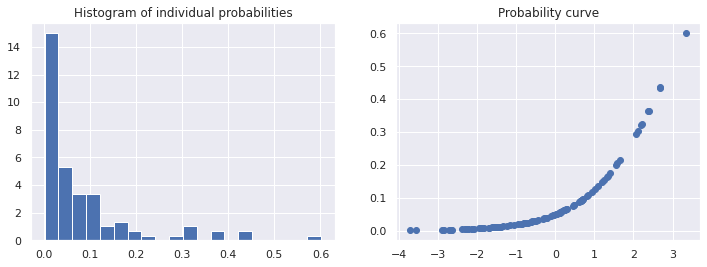

In [401]:
beta = np.array([-0.1, 2.5, 1.4, -1.8, 0.3])

data,  theta = simulation(n_samples=100, 
                          normal_parameters={'n_pred': 3, 'mean': np.zeros(3), 'cov': np.eye(3)}, 
                          cauchy_parameters={'n_pred': 0, 'mean': np.zeros(3), 'scale': np.ones(3)}, 
                          discrete_parameters={'n_pred': 2, 'p': [0.3, 0.7]},
                          beta=beta,
                          prevalence=0.05,
                          seed = 489320
                         )

fit_perfect = sm.sampling(data=data, iter=2000, pars = ['prev', 'effects'])
summary = az.summary(fit_perfect)

theta = expit(logit(0.9) + data["X"]@beta)
np.random.seed(10000)
data["Y"] = np.random.binomial(n = 1, p = theta)

fit_perfect = sm.sampling(data=data, iter=2000, pars = ['prev', 'effects'])
summary2 = az.summary(fit_perfect)

<ipython-input-402-67323401ef9a>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[r"$\beta_{}$".format(i) for i in range(6)], fontsize = 20)


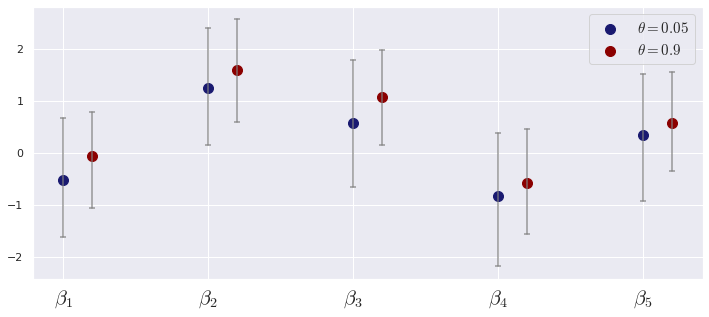

In [402]:
fig, ax = plt.subplots(figsize = (12,5))

for i in range(summary.shape[0]-1): 
    par = "effects[{}]".format(i)
    ax.plot([i,i], [summary.loc[par,"hdi_3%"], summary.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8)
    ax.plot([i+0.2,i+0.2], [summary2.loc[par,"hdi_3%"], summary2.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8)
    ax.scatter([i,i], [summary.loc[par,"hdi_3%"], summary.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8, marker = '_')
    ax.scatter([i+0.2,i+0.2], [summary2.loc[par,"hdi_3%"], summary2.loc[par,"hdi_97%"]], color = 'grey', alpha = 0.8, marker = '_')

ax.scatter(range(summary.shape[0]-1), summary["mean"].values[1:], color = 'midnightblue', s = 100, label = r"$\theta = 0.05$")
ax.scatter(0.2+np.arange(summary2.shape[0]-1), summary2["mean"].values[1:], color = 'darkred', s = 100, label = r"$\theta = 0.9$")

ax.legend(fontsize = 15)

ticks_loc = ax.get_xticks().tolist()
ax.set_xticklabels(labels=[r"$\beta_{}$".format(i) for i in range(6)], fontsize = 20)

plt.savefig("../images/comparing-diff-prevalence-perfect-tests.pdf", bbox_inches = "tight")
plt.show()

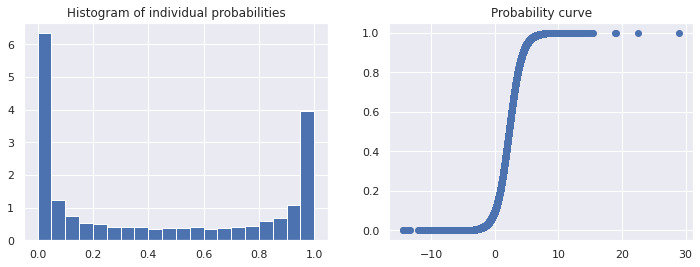

In [504]:
np.random.seed(500)
beta = np.random.normal(scale = 2, size = 50)*np.random.binomial(n=1, p=0.3, size=50)

data,  theta = simulation(n_samples=5000, 
                          normal_parameters={'n_pred': 40, 'mean': np.zeros(40), 'cov': np.eye(40)}, 
                          cauchy_parameters={'n_pred': 5, 'mean': np.zeros(5), 'scale': np.ones(5)}, 
                          discrete_parameters={'n_pred': 5, 'p': [0.2, 0.4, 0.7, 0.8, 0.9]},
                          beta=beta,
                          prevalence=0.1,
                          seed = 132
                         )

fit_perfect = sm.sampling(data=data, iter=2000, pars = ['prev', 'effects'])
summary = az.summary(fit_perfect)
summary.insert(0, 'real_values', (0.1, *tuple(beta.flatten())))

In [505]:
summary[(summary.real_values > summary["hdi_3%"])&(summary.real_values < summary["hdi_97%"])].shape

(48, 10)

In [508]:
logit_theta_hat_samples = logit(fit_perfect.extract()['prev']) + (fit_perfect.extract()['effects']@data['X'].transpose()).transpose()
theta_hat_samples = expit(logit_theta_hat_samples)
credible_interval = np.quantile(theta_hat_samples, axis=1, q=[0.03, 0.97])
theta_hat = theta_hat_samples.mean(axis=1)

df = pd.DataFrame({'mean': theta_hat, 
                   'real': theta,
                   'CI_3': credible_interval[0,:],
                   'CI_97': credible_interval[1,:]}).sort_values('mean')

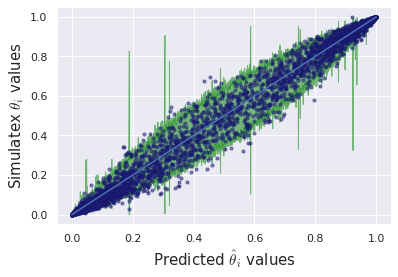

In [513]:
fig, ax = plt.subplots()
ax.fill_between(x = df['mean'], 
                y1 = df['CI_3'], 
                y2 = df['CI_97'],
                alpha = 0.5, 
                color = 'green')
ax.scatter(df['mean'], df['real'], color = 'midnightblue', s = 10, alpha = 0.5)
ax.plot(np.linspace(min(df['mean']), max(df['mean']), 100), np.linspace(min(df['mean']), max(df['mean']), 100))

ax.set_xlabel(r"Predicted $\hat{\theta}_i$ values", fontsize = 15)
ax.set_ylabel(r"Simulatex $\theta_i$ values", fontsize = 15)

plt.savefig("../images/predicted-vs-simulated-high-dimension-perfect-tests.pdf", bbox_inches="tight")